## Setup: Import Libraries and Configure Backend

Import necessary libraries and set up the PyTorch backend for Keras.


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, SimpleRNN, Dense, Dropout
from keras.optimizers import Adam

In [2]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")



Detected Linux: defaulting to Torch backend
Final Keras backend: Torch


In [5]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()



GPU available: Tesla T4
Using GPU


## Preprocessing Data: Loading / Clean the Dataset




In [22]:
df = pd.read_csv('household_power_consumption.txt', sep=';')

/tmp/ipython-input-4116954226.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')


In [23]:
display(df.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [24]:
# Convert relevant columns to numeric
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [25]:
#Look at the missing values
df.isnull().sum()

#Fill with the forward fill method
df.fillna(method='ffill', inplace=True)

/tmp/ipython-input-3054071582.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [26]:
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [27]:
#Converting to datetime for time series analysis
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format = "%d/%m/%Y %H:%M:%S")
df.drop(['Date', 'Time'], axis = 1, inplace = True)

#order the values by datetime / make datetime the index
df.sort_values('datetime', inplace=True)

#make datetime the index
df.set_index('datetime', inplace=True)


In [28]:
# Resample the data to be hourly
df_hour = df.resample('h').mean()

#NaNs per column right after resample
print(df_hour.isna().sum())

# Fix them
df_hour = df_hour.ffill().bfill()

#NaNs per column AFTER cleaning
print(df_hour.isna().sum())

df_hour.describe().T

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,1.086200,0.894942,0.124000,0.341267,0.799533,1.574967,6.560533
Global_reactive_power,34589.0,0.123326,0.067221,0.000000,0.077667,0.106767,0.149367,0.774333
Voltage,34589.0,240.841505,2.999127,225.834500,239.197167,240.984500,242.691833,251.902000
Global_intensity,34589.0,4.604360,3.746337,0.503333,1.510000,3.406667,6.583333,28.383333
Sub_metering_1,34589.0,1.110951,3.518498,0.000000,0.000000,0.000000,0.000000,48.366667
Sub_metering_2,34589.0,1.287914,4.168720,0.000000,0.000000,0.333333,0.650000,46.433333
Sub_metering_3,34589.0,6.416515,7.344718,0.000000,0.650000,1.650000,14.083333,21.550000


# Train / Validation / Test Split


## Data Preprocessing for Time Series Prediction

**Critical: Preventing Data Leakage**

The correct preprocessing sequence is:

1. **Split first** → Divide dataset into train (70%), validation (15%), and test (15%) sets
2. **Scale with rolling statistics**
3. **Create sliding windows**


**Scaling Approach:**
- At validation/test time, we use all available historical data (including training data)
- This mimics real-world scenario where you have access to all past data


###  Data Splitting

In [29]:
# 70% train, 15% val, 15% test (time order preserved)
n = len(df_hour)

# compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n) # 70% + 15%

# Split without shuffling (important for time series!)
train = df_hour.iloc[:train_end]
val = df_hour.iloc[train_end:val_end]
test = df_hour.iloc[val_end:]

print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")
train.head()


Train shape: (24212, 7), Validation shape: (5188, 7), Test shape: (5189, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


## Scaling Features and Target

In [30]:
# Columns
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
y_col = 'Global_active_power'

# Scaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# fitting and transform
X_train_scaled = scaler_X.fit_transform(train[X_cols]) # only fit for trianing
X_val_scaled = scaler_X.transform(val[X_cols])
X_test_scaled = scaler_X.transform(test[X_cols])
y_train_scaled = scaler_Y.fit_transform(train[[y_col]])
y_val_scaled = scaler_Y.transform(val[[y_col]])
y_test_scaled = scaler_Y.transform(test[[y_col]])


In [31]:
# Going back into dfs before sliding windows
# df
X_train_scaled = pd.DataFrame(X_train_scaled, index=train.index, columns=X_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, index=val.index,columns=X_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,index=test.index,columns=X_cols)

print("X_train_scaled shape:",X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:",y_train_scaled.shape)
print("y_val_scaled shape:", y_val_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (24212, 6)
X_val_scaled shape: (5188, 6)
X_test_scaled shape: (5189, 6)
y_train_scaled shape: (24212, 1)
y_val_scaled shape: (5188, 1)
y_test_scaled shape: (5189, 1)


## Rolling windows for 24-hour lookback

In [32]:
def create_sliding_windows(X_df, y_array, look_back=24, forecast_horizon=1):
    X_windows = []
    y_windows = []
    X_values = X_df.values
    y_values = y_array.reshape(-1)
    for i in range(len(X_df) - look_back - forecast_horizon + 1):
        X_windows.append(X_values[i:i + look_back, :])
        y_windows.append(y_values[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)

look_back = 24 # hours

X_train_seq, y_train_seq = create_sliding_windows(X_train_scaled, y_train_scaled)
X_val_seq, y_val_seq = create_sliding_windows(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq= create_sliding_windows(X_test_scaled,y_test_scaled)

print("X_train_seq:",X_train_seq.shape)
print("X_val_seq:", X_val_seq.shape)
print("X_test_seq:", X_test_seq.shape)


X_train_seq: (24188, 24, 6)
X_val_seq: (5164, 24, 6)
X_test_seq: (5165, 24, 6)


# Model Tests with RNN

## 1: Simple RNN Model

### Steps

1. **Define** the RNN model architecture.  
2. **Compile** the model with an appropriate loss function and optimizer.  
3. **Train** the model using an early stopping callback, allowing a large number of epochs without overfitting.  
4. **Visualize** the training process by plotting the learning curves.  
5. **Generate predictions** on the test data.  
6. **Inverse transform** predictions back to the original price scale.  
7. **Evaluate** model performance using RMSE and MAE on the original scale.



In [33]:
# baseline rnn model
baseline_rnn = Sequential()
baseline_rnn.add(Input(shape=(look_back, X_train_seq.shape[2])))
baseline_rnn.add(SimpleRNN(64,activation='tanh'))
baseline_rnn.add(Dense(1))

#compiling
baseline_rnn.compile(optimizer='adam', loss='mse')

#looking at baseline
baseline_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5,restore_best_weights=True)

history_rnn_model = baseline_rnn.fit(X_train_seq, y_train_seq,
    epochs=30, batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False,  #for time series
    callbacks=[early_stopping],verbose=1)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.8111 - val_loss: 0.4605
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4681 - val_loss: 0.4115
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4333 - val_loss: 0.3923
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4219 - val_loss: 0.3881
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4145 - val_loss: 0.3864
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4089 - val_loss: 0.3865
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4018 - val_loss: 0.3913
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3949 - val_loss: 0.3823
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3919 - val_loss: 0.3830
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.3861 - val_loss: 0.3849
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3834 - val_loss: 0.3803
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

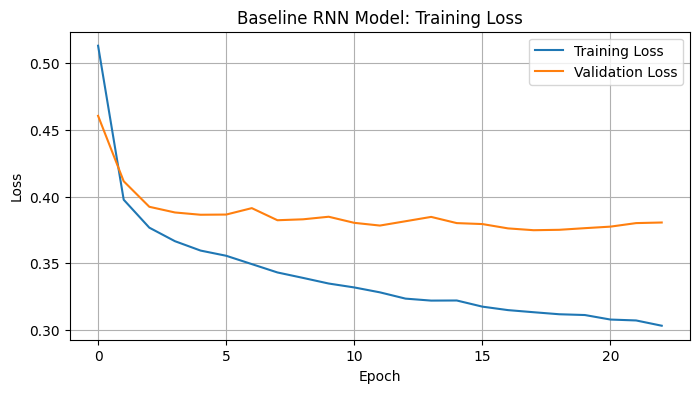

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_model.history['loss'], label='Training Loss')
plt.plot(history_rnn_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline RNN Model: Training Loss')
plt.legend()
plt.grid(True)
plt.show()

The gap between training and validation loss is modest. The training loss decreases steadily while validation loss levels off after the first few epochs. The modest gap between the curves suggests mild overfitting, but the plateau indicates that the model is also underfitting the underlying temporal structure.

#### Predictions + Performance Evaluation


In [37]:
# predictions
train_pred_rnn = baseline_rnn.predict(X_train_seq)
val_pred_rnn = baseline_rnn.predict(X_val_seq)
test_pred_rnn = baseline_rnn.predict(X_test_seq)

# inverse transforming
train_pred_inv = scaler_Y.inverse_transform(train_pred_rnn)
val_pred_inv= scaler_Y.inverse_transform(val_pred_rnn)
test_pred_inv = scaler_Y.inverse_transform(test_pred_rnn)

train_y_inv = scaler_Y.inverse_transform(y_train_seq.reshape(-1, 1))
val_y_inv = scaler_Y.inverse_transform(y_val_seq.reshape(-1, 1))
test_y_inv = scaler_Y.inverse_transform(y_test_seq.reshape(-1, 1))


756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [39]:
# TEST
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_pred_inv))
test_mae = mean_absolute_error(test_y_inv, test_pred_inv)


# Train
train_rmse = np.sqrt(mean_squared_error(train_y_inv, train_pred_inv))
train_mae = mean_absolute_error(train_y_inv, train_pred_inv)

# Validation
val_rmse = np.sqrt(mean_squared_error(val_y_inv, val_pred_inv))

print("Test RMSE:", test_rmse, "MAE:", test_mae)
print("Train RMSE:", train_rmse, "MAE:", train_mae)
print("Val RMSE:", val_rmse)

Test RMSE: 0.49011478458111707 MAE: 0.34391314262548395
Train RMSE: 0.54306448873784 MAE: 0.3751466495491324
Val RMSE: 0.5679145442671197


- Train, validation, and test RMSE are relatively close (0.54, 0.57, and 0.49 kW, respectively)
- the baseline RNN generalizes moderately well, and the slightly higher validation error reflects mild overfitting

### Visualizing RNN predictions vs. the actual values


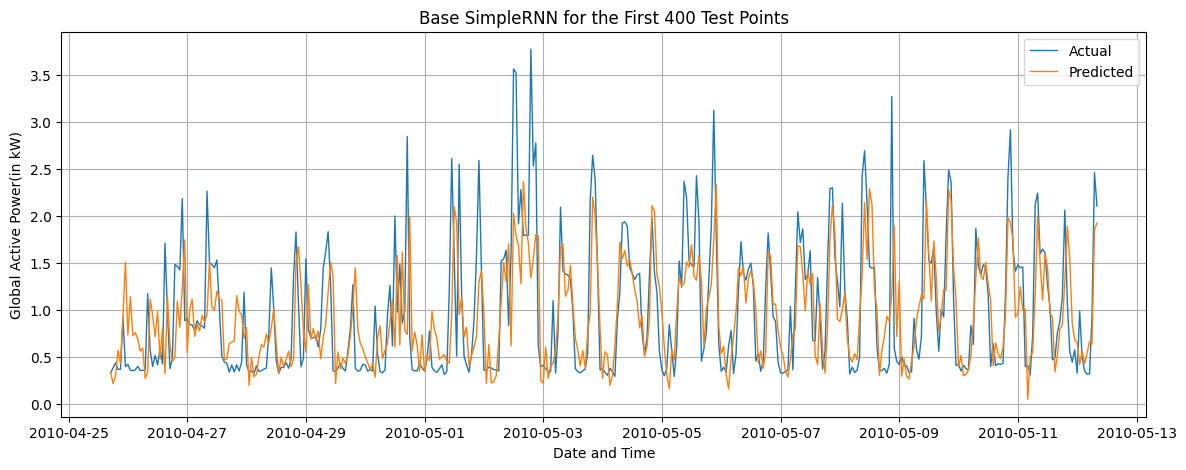

In [40]:
#for the first 400 points
test_index_for_windows = test.index[look_back:]

plt.figure(figsize=(14, 5))
plt.grid(True)
plt.plot(test_index_for_windows[:400], test_y_inv[:400], label='Actual', linewidth=1)
plt.plot(test_index_for_windows[:400], test_pred_inv[:400], label='Predicted', linewidth=1)
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power(in kW)')
plt.title('Base SimpleRNN for the First 400 Test Points')
plt.legend()
plt.show()


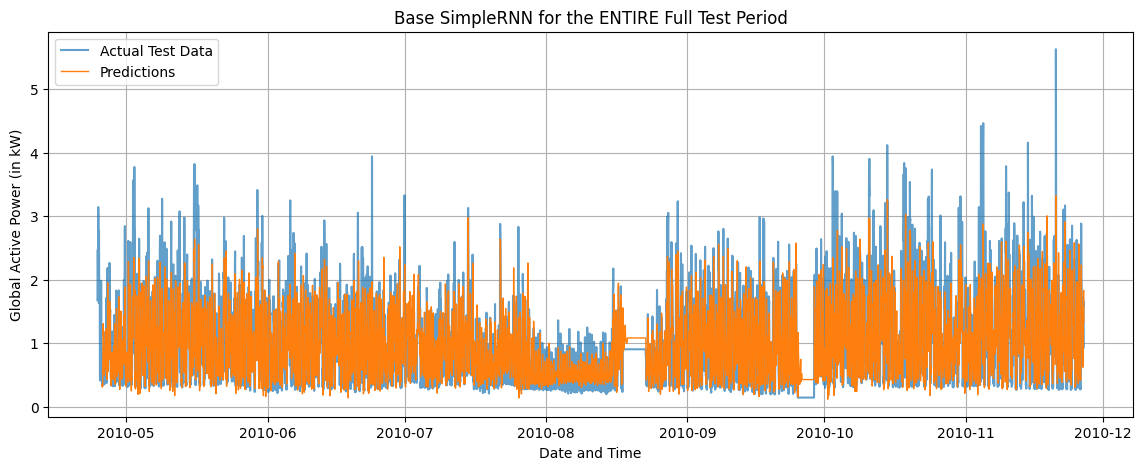

In [31]:
# for the entire test period

plt.figure(figsize=(14, 5))
plt.grid(True)
plt.plot(test.index, test[y_col], label='Actual Test Data', alpha=0.7)
plt.plot(test_index_for_windows, test_pred_inv, label='Predictions', linewidth=1)
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (in kW)')
plt.title('Base SimpleRNN for the ENTIRE Full Test Period')
plt.legend()
plt.show()


- This model seems to capture the broad daily fluctuations in power usage.
- But, it performed poorly on many of the sudden spikes + sharp transitions. It also looks like the model tended to not fully reach lower points in addition to high-demand peaks. This makes sense for this simmple model because it might have issues with vanishing gradients and learning longterm dependencies on temperature.

# 2nd RNN Model: More improved


#### Model Change
- Added a second SimpleRNN layer (so 64 to 32 units)
- Introduced Dropout with rate = 0.3
- Set return_sequences=True in first RNN layer.
- Increased training max amount of epochs from 30 → 40


In [41]:
deep_rnn = Sequential()
deep_rnn.add(Input(shape=(look_back, X_train_seq.shape[2])))

#layer 1
deep_rnn.add(SimpleRNN(64, activation='tanh', return_sequences=True))
deep_rnn.add(Dropout(0.3)) # trying dropout rate of 0.3

# layer 2
deep_rnn.add(SimpleRNN(32, activation='tanh'))
deep_rnn.add(Dropout(0.3))

#output
deep_rnn.add(Dense(1))

deep_rnn.compile(optimizer='adam', loss='mse')
deep_rnn.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 24, 64)         │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# training

early_stopping_deep_rnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_deep_rnn = deep_rnn.fit( X_train_seq, y_train_seq,
    epochs=40, batch_size=32,
    validation_data=(X_val_seq, y_val_seq), shuffle=False,
    callbacks=[early_stopping_deep_rnn],verbose=1)

Epoch 1/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.9943 - val_loss: 0.5043
Epoch 2/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5842 - val_loss: 0.4803
Epoch 3/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5403 - val_loss: 0.4567
Epoch 4/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5086 - val_loss: 0.4649
Epoch 5/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4979 - val_loss: 0.4333
Epoch 6/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4927 - val_loss: 0.4722
Epoch 7/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4840 - val_loss: 0.4506
Epoch 8/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4767 - val_loss: 0.4186
Epoch 9/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4740 - val_loss: 0.3993
Epoch 10/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4691 - val_loss: 0.4172
Epoch 11/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.4579 - val_loss: 0.4239
Epoch 12/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/s

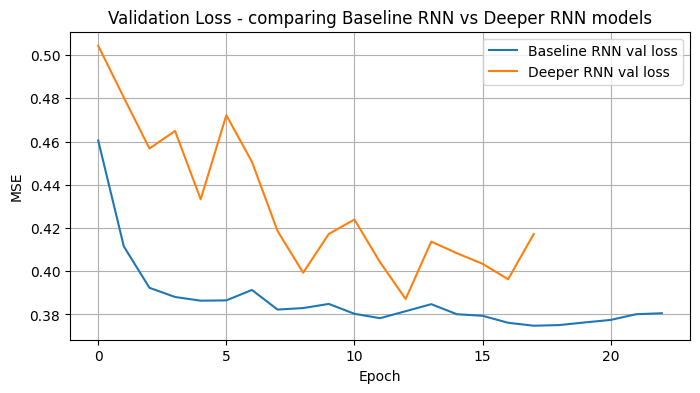

In [43]:
# plotting basline model vs. deep model
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_model.history['val_loss'],label='Baseline RNN val loss')
plt.plot(history_deep_rnn.history['val_loss'], label='Deeper RNN val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss - comparing Baseline RNN vs Deeper RNN models')
plt.legend()
plt.grid(True)
plt.show()

##### Predictions


In [44]:
# predict
train_pred_deep = deep_rnn.predict(X_train_seq)
val_pred_deep = deep_rnn.predict(X_val_seq)
test_pred_deep = deep_rnn.predict(X_test_seq)

# inv transform
train_pred_deep_inv = scaler_Y.inverse_transform(train_pred_deep)
val_pred_deep_inv = scaler_Y.inverse_transform(val_pred_deep)
test_pred_deep_inv= scaler_Y.inverse_transform(test_pred_deep)

# performance
# TEST
test_rmse_deep = np.sqrt(mean_squared_error(test_y_inv, test_pred_deep_inv))
test_mae_deep = mean_absolute_error(test_y_inv, test_pred_deep_inv)

# TRAIN
train_rmse_deep = np.sqrt(mean_squared_error(train_y_inv, train_pred_deep_inv))
train_mae_deep = mean_absolute_error(train_y_inv, train_pred_deep_inv)

# VALIDATION
val_rmse_deep = np.sqrt(mean_squared_error(val_y_inv, val_pred_deep_inv))
val_mae_deep = mean_absolute_error(val_y_inv, val_pred_deep_inv)

print("Test  RMSE:", test_rmse_deep,  "MAE:", test_mae_deep)
print("Train RMSE:", train_rmse_deep, "MAE:", train_mae_deep)
print("Val RMSE:", val_rmse_deep)

756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test  RMSE: 0.4889126646321768 MAE: 0.3402191381487703
Train RMSE: 0.5792020429068002 MAE: 0.3912784284751988
Val RMSE: 0.5771905044509974


The deeper model’s val loss is higher and more unstable than the baseline, and its train RMSE is also slightly worse. Test RMSE is nearly identical with the baseline model(~0.49 kW), so this can suggest that the added depth did not actually yield a meaningful improvement in generalization performance unfortunately

# Tuning the model

I will trying making the model better with the time-based features (hour_cos, dow_sin, etc.) and by tuning the units and dropout.

In [46]:
# Adding calendar features
df_hour['hour'] = df_hour.index.hour
df_hour['dayofweek'] = df_hour.index.dayofweek        # 0 = Monday, 6 = Sunday
df_hour['is_weekend'] = (df_hour['dayofweek'] >= 5).astype(int)

# Cyclical encoding for hour of day (for 24 hours)
df_hour['hour_sin'] = np.sin(2 * np.pi * df_hour['hour'] / 24)
df_hour['hour_cos'] = np.cos(2 * np.pi * df_hour['hour'] / 24)

# Cyclical encoding for day of week (for 7 days)
df_hour['dow_sin'] = np.sin(2 * np.pi * df_hour['dayofweek'] / 7)
df_hour['dow_cos'] = np.cos(2 * np.pi * df_hour['dayofweek'] / 7)

In [47]:
# re-splitting
n = len(df_hour)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train = df_hour.iloc[:train_end]
val   = df_hour.iloc[train_end:val_end]
test  = df_hour.iloc[val_end:]

In [48]:
# adding new time feaatures to the columns

X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']
y_col = 'Global_active_power'

In [49]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# fit and transform
X_train_scaled = scaler_X.fit_transform(train[X_cols])
X_val_scaled = scaler_X.transform(val[X_cols])
X_test_scaled = scaler_X.transform(test[X_cols])
y_train_scaled = scaler_Y.fit_transform(train[[y_col]])
y_val_scaled = scaler_Y.transform(val[[y_col]])
y_test_scaled = scaler_Y.transform(test[[y_col]])

# for df
X_train_scaled = pd.DataFrame(X_train_scaled,index=train.index, columns=X_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, index=val.index, columns=X_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,index=test.index,columns=X_cols)


In [50]:
#slidign windows

look_back = 24

X_train_seq, y_train_seq = create_sliding_windows(X_train_scaled, y_train_scaled)
X_val_seq, y_val_seq = create_sliding_windows(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq = create_sliding_windows(X_test_scaled,y_test_scaled)

y_train_seq = y_train_seq.reshape(-1, 1)
y_val_seq = y_val_seq.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# inverse
train_y_inv = scaler_Y.inverse_transform(y_train_seq)
val_y_inv = scaler_Y.inverse_transform(y_val_seq)
test_y_inv = scaler_Y.inverse_transform(y_test_seq)

## Model A: Testing a model with 32 units and dropout = 0.2


#### Model Changes
- adding time-based features, such as hour_sin and hour_cos
- reduced hidden layer size from 64-->32 and 32 -->16 unites
- changed dropout from 0.3 --> 0.2

In [52]:

units_A = 32
dropout_A = 0.2

deep_rnn_A = Sequential()
deep_rnn_A.add(Input(shape=(look_back, X_train_seq.shape[2])))
deep_rnn_A.add(SimpleRNN(32, activation='tanh', return_sequences=True))
deep_rnn_A.add(Dropout(0.2))
deep_rnn_A.add(SimpleRNN(16, activation='tanh'))
deep_rnn_A.add(Dropout(0.2))
deep_rnn_A.add(Dense(1))

deep_rnn_A.compile(optimizer='adam', loss='mse')

early_stop_A = EarlyStopping(monitor='val_loss', patience=5,
    start_from_epoch=5,restore_best_weights=True)

history_A = deep_rnn_A.fit(X_train_seq, y_train_seq,
    epochs=30,batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False,callbacks=[early_stop_A],
    verbose=1)

# predictions + metrics
train_pred_A = deep_rnn_A.predict(X_train_seq)
val_pred_A = deep_rnn_A.predict(X_val_seq)
test_pred_A= deep_rnn_A.predict(X_test_seq)

train_pred_A_inv = scaler_Y.inverse_transform(train_pred_A)
val_pred_A_inv = scaler_Y.inverse_transform(val_pred_A)
test_pred_A_inv = scaler_Y.inverse_transform(test_pred_A)

train_rmse_A = np.sqrt(mean_squared_error(train_y_inv, train_pred_A_inv))
train_mae_A = mean_absolute_error(train_y_inv, train_pred_A_inv)
test_rmse_A = np.sqrt(mean_squared_error(test_y_inv, test_pred_A_inv))
test_mae_A = mean_absolute_error(test_y_inv,test_pred_A_inv)
val_rmse_A = np.sqrt(mean_squared_error(val_y_inv, val_pred_A_inv))

print("Model A (units=32, dropout=0.2)")
print("Train RMSE:", train_rmse_A, "MAE:", train_mae_A)
print("Test RMSE:", test_rmse_A, "MAE:", test_mae_A)
print("ValRMSE:", val_rmse_A)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 1.0186 - val_loss: 0.5180
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6135 - val_loss: 0.4391
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5437 - val_loss: 0.4191
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5032 - val_loss: 0.4130
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4914 - val_loss: 0.4010
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4812 - val_loss: 0.3864
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4711 - val_loss: 0.3853
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4631 - val_loss: 0.3904
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4577 - val_loss: 0.3840
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4519 - val_loss: 0.3834
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4502 - val_loss: 0.3780
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/st

Model A got a similar train and validation error to the deeper RNN model (comparing Train RMSE ≈ 0.56 vs 0.58, Val RMSE ≈ 0.56 vs 0.58), but slightly improves test performance (Test RMSE ≈ 0.47 vs ~0.49 kW).

So, adding time-based features and slightly simplifying the architecture helped the model generalize a bit better to unseen data without overfitting!!!

## Model B: Testing a model with 64 units and dropout = 0.4


#### Model Changes
- increased hidden units from 32 --> 64 and 16 --> 32 (bringing it back to before model A)
- changed dropout rate 0.2 --> 0.4 for more regularizatoin

In [53]:
units_B = 64
dropout_B = 0.4

deep_rnn_B = Sequential()
deep_rnn_B.add(Input(shape=(look_back, X_train_seq.shape[2])))
deep_rnn_B.add(SimpleRNN(64, activation='tanh', return_sequences=True))
deep_rnn_B.add(Dropout(0.4))
deep_rnn_B.add(SimpleRNN(32, activation='tanh'))
deep_rnn_B.add(Dropout(0.4))
deep_rnn_B.add(Dense(1))

deep_rnn_B.compile(optimizer='adam', loss='mse')

early_stop_B = EarlyStopping(monitor='val_loss',
    patience=5,start_from_epoch=5,
    restore_best_weights=True)

history_B = deep_rnn_B.fit(X_train_seq, y_train_seq,
    epochs=30, batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False, callbacks=[early_stop_B], verbose=1)

# predictions + metrics
train_pred_B = deep_rnn_B.predict(X_train_seq)
val_pred_B = deep_rnn_B.predict(X_val_seq)
test_pred_B = deep_rnn_B.predict(X_test_seq)

train_pred_B_inv = scaler_Y.inverse_transform(train_pred_B)
val_pred_B_inv = scaler_Y.inverse_transform(val_pred_B)
test_pred_B_inv= scaler_Y.inverse_transform(test_pred_B)

train_rmse_B = np.sqrt(mean_squared_error(train_y_inv, train_pred_B_inv))
train_mae_B = mean_absolute_error(train_y_inv, train_pred_B_inv)
test_rmse_B = np.sqrt(mean_squared_error(test_y_inv,test_pred_B_inv))
test_mae_B = mean_absolute_error(test_y_inv,test_pred_B_inv)
val_rmse_B = np.sqrt(mean_squared_error(val_y_inv, val_pred_B_inv))

print("Train RMSE:", train_rmse_B, "MAE:", train_mae_B)
print("TestRMSE:", test_rmse_B, "MAE:", test_mae_B)
print("ValRMSE:", val_rmse_B)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.4851 - val_loss: 0.5028
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6377 - val_loss: 0.4558
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5600 - val_loss: 0.4377
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5307 - val_loss: 0.4345
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5130 - val_loss: 0.4141
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4988 - val_loss: 0.4045
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4881 - val_loss: 0.4086
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4836 - val_loss: 0.3962
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4718 - val_loss: 0.3911
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4697 - val_loss: 0.3851
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4635 - val_loss: 0.3876
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/st

Model B gave me a slightly higher train and val error than Model A. (Train RMSE ≈ 0.58 vs 0.56, Val RMSE ≈ 0.58 vs 0.56). It also led to a smaller worse test RMSE (≈0.48 vs 0.47 kW). So, I think that increasing the units and dropout on top of the time-based features did not improve generalization. The more compact Model A is the better model for the rnn models I've tested so far.

## Model C - adding a layers

#### Model Change
- adding a third RNN layer
- 64 in two layers, 32 units in the second
- dropout rate --> 0.3

In [54]:

units_C = 64
dropout_C = 0.3

deep_rnn_C = Sequential()
deep_rnn_C.add(Input(shape=(look_back, X_train_seq.shape[2])))

# layer 1
deep_rnn_C.add(SimpleRNN( 64, activation='tanh', return_sequences=True))
deep_rnn_C.add(Dropout(0.3))

# layer 2
deep_rnn_C.add(SimpleRNN( 64, activation='tanh', return_sequences=True))
deep_rnn_C.add(Dropout(0.3))

# layer 3
deep_rnn_C.add(SimpleRNN( 64 // 2, activation='tanh'))
deep_rnn_C.add(Dropout(0.3))

# output
deep_rnn_C.add(Dense(1))

deep_rnn_C.compile(optimizer='adam', loss='mse')
deep_rnn_C.summary()

early_stop_C = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5, restore_best_weights=True)

history_C = deep_rnn_C.fit( X_train_seq, y_train_seq,
    epochs=30, batch_size=32, validation_data=(X_val_seq, y_val_seq),
    shuffle=False, callbacks=[early_stop_C], verbose=1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 24, 64)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 24, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 1.1080 - val_loss: 0.5030
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6209 - val_loss: 0.4636
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.5472 - val_loss: 0.4417
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.5267 - val_loss: 0.4159
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4974 - val_loss: 0.4190
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4928 - val_loss: 0.4002
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4824 - val_loss: 0.3901
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4681 - val_loss: 0.3769
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4624 - val_loss: 0.3873
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4637 - val_loss: 0.3809
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4546 - val_loss: 0.3873
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms

In [55]:
# Predictions
train_pred_C = deep_rnn_C.predict(X_train_seq)
val_pred_C = deep_rnn_C.predict(X_val_seq)
test_pred_C= deep_rnn_C.predict(X_test_seq)

train_pred_C_inv = scaler_Y.inverse_transform(train_pred_C)
val_pred_C_inv= scaler_Y.inverse_transform(val_pred_C)
test_pred_C_inv = scaler_Y.inverse_transform(test_pred_C)

train_rmse_C = np.sqrt(mean_squared_error(train_y_inv, train_pred_C_inv))
train_mae_C = mean_absolute_error(train_y_inv,train_pred_C_inv)

val_rmse_C = np.sqrt(mean_squared_error(val_y_inv,val_pred_C_inv))
val_mae_C= mean_absolute_error(val_y_inv,val_pred_C_inv)

test_rmse_C= np.sqrt(mean_squared_error(test_y_inv, test_pred_C_inv))
test_mae_C= mean_absolute_error(test_y_inv,test_pred_C_inv)

print("Train RMSE:", train_rmse_C, "MAE:", train_mae_C)
print("Test RMSE:", test_rmse_C,"MAE:", test_mae_C)
print("ValRMSE:", val_rmse_C)


756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train RMSE: 0.5646337768369742 MAE: 0.39254496384380366
Test RMSE: 0.47387456974092657 MAE: 0.3408070807368958
ValRMSE: 0.5615701456232787


Adding a 3rd RNN layer (64→64→32 units) really didn’t fundamentally change performance. It kept me with around the same performance as Models A/B. There was some modest improvement over the simple baseline but no big gain over the best tuned model of Model A.

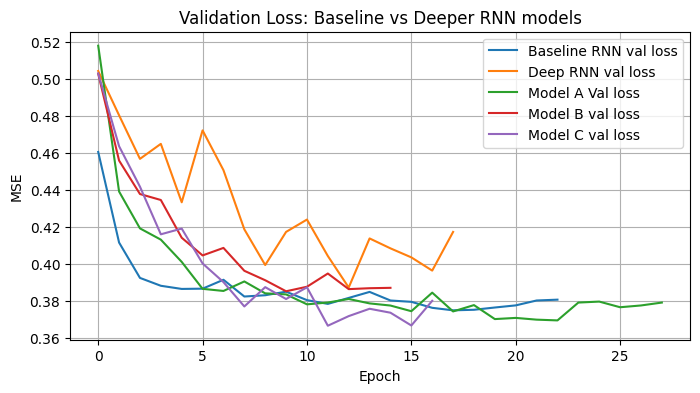

In [58]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn_model.history['val_loss'], label='Baseline RNN val loss')
plt.plot(history_deep_rnn.history['val_loss'], label='Deep RNN val loss')
plt.plot(history_A.history['val_loss'], label='Model A Val loss')
plt.plot(history_B.history['val_loss'], label='Model B val loss')
plt.plot(history_C.history['val_loss'], label='Model C val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss: Baseline vs Deeper RNN models')
plt.legend()
plt.grid(True)
plt.show()


Model A creates the strongest generalization performance. The baseline RNN performs reasonably well, but Model A consistently achieves lower val error across epochs. This indicates that the combo of cyclical time features and a compact two-layer architecture improves forecasting ability. Models B and C reduce variance compared to the deeper RNN but do not surpass Model A. Also, the original deep RNN underperforms all other architectures with obviously higher and noisier validation loss.

So overall, Model A is the most stable and best-performing model in this comparison.


### Model D - changing the learning rate
Reasoning: In the LTSM model, we found that adding a smaller learning rate of 0.001 was beneficial, so I'd like to try adding a smaller learning rate for RNN as well



#### Model Changes
- the model is the same at Model C, but I changed the learning rate to 0.0005
- I alsoo allowed up to 40 epochs (vs 30 for Model C)

In [59]:
# for Model D, is has the same architecture as Model C, but just a smaller learning rate

rnn_learning_rate_change = Sequential()
rnn_learning_rate_change.add(Input(shape=(look_back, X_train_seq.shape[2])))

# 3layer rnn
rnn_learning_rate_change.add(SimpleRNN(64, activation="tanh", return_sequences=True))
rnn_learning_rate_change.add(Dropout(0.3))

rnn_learning_rate_change.add(SimpleRNN(64, activation="tanh", return_sequences=True))
rnn_learning_rate_change.add(Dropout(0.3))

rnn_learning_rate_change.add(SimpleRNN(32, activation="tanh"))
rnn_learning_rate_change.add(Dropout(0.3))

rnn_learning_rate_change.add(Dense(1))

# CHANGING LEARNING RATE
optimizer_change = Adam(learning_rate=0.0005)
rnn_learning_rate_change.compile(optimizer=optimizer_change, loss="mse")



In [60]:
early_stop_lrc = EarlyStopping(monitor="val_loss",
    patience=5, start_from_epoch=5,
    restore_best_weights=True)

history_rnn_lrc = rnn_learning_rate_change.fit(X_train_seq, y_train_seq,
    epochs=40, batch_size=32,
    validation_data=(X_val_seq, y_val_seq), shuffle=False,
    callbacks=[early_stop_lrc], verbose=1)

Epoch 1/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 1.0826 - val_loss: 0.4725
Epoch 2/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6661 - val_loss: 0.4536
Epoch 3/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.5823 - val_loss: 0.4339
Epoch 4/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.5544 - val_loss: 0.4194
Epoch 5/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5288 - val_loss: 0.4125
Epoch 6/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.5146 - val_loss: 0.3981
Epoch 7/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4999 - val_loss: 0.3933
Epoch 8/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4909 - val_loss: 0.3911
Epoch 9/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4813 - val_loss: 0.3924
Epoch 10/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4779 - val_loss: 0.3863
Epoch 11/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4720 - val_loss: 0.3689
Epoch 12/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s

In [61]:
#predicting
train_pred_D = rnn_learning_rate_change.predict(X_train_seq)
val_pred_D = rnn_learning_rate_change.predict(X_val_seq)
test_pred_D= rnn_learning_rate_change.predict(X_test_seq)

# inverse transform
train_pred_D_inv = scaler_Y.inverse_transform(train_pred_D)
val_pred_D_inv= scaler_Y.inverse_transform(val_pred_D)
test_pred_D_inv= scaler_Y.inverse_transform(test_pred_D)

#metrics
train_rmse_D = np.sqrt(mean_squared_error(train_y_inv, train_pred_D_inv))
train_mae_D = mean_absolute_error(train_y_inv, train_pred_D_inv)
test_rmse_D = np.sqrt(mean_squared_error(test_y_inv, test_pred_D_inv))
test_mae_D = mean_absolute_error(test_y_inv, test_pred_D_inv)

val_rmse_D = np.sqrt(mean_squared_error(val_y_inv, val_pred_D_inv))

print("Train RMSE:", train_rmse_D)
print("Train MAE:", train_mae_D)
print("Val RMSE:", val_rmse_D)

print("Test RMSE:", test_rmse_D)
print("Test MAE:", test_mae_D)

756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train RMSE: 0.5688686875737691
Train MAE: 0.3866745039548049
Val RMSE: 0.563459732723726
Test RMSE: 0.4730667824191101
Test MAE: 0.3326338492522804


RMSE is basically unchanged vs Model C (tiny, statistically meaningless differences). So, lowering the learning rate to 0.0005 did not really change model performance. It only could habe made optimization a bit smoother.

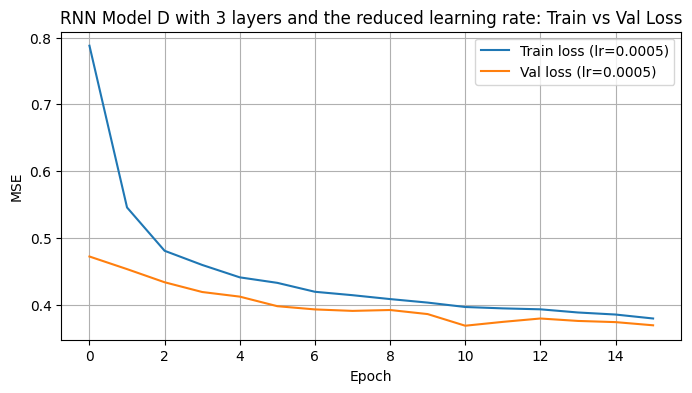

In [63]:
# plotting
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_lrc.history["loss"],label="Train loss (lr=0.0005)")
plt.plot(history_rnn_lrc.history["val_loss"], label="Val loss (lr=0.0005)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("RNN Model D with 3 layers and the reduced learning rate: Train vs Val Loss")
plt.legend()
plt.grid(True)
plt.show()



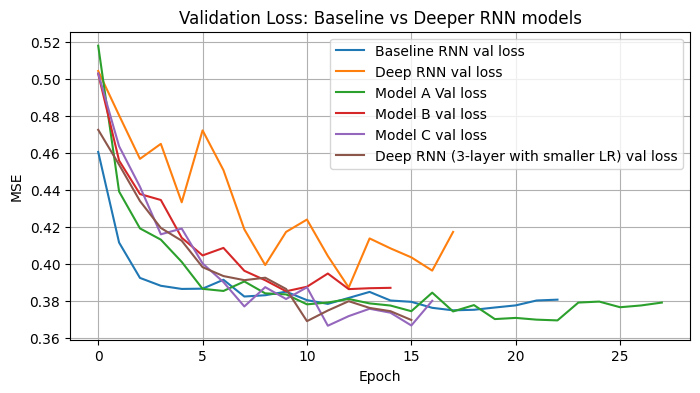

In [64]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn_model.history['val_loss'], label='Baseline RNN val loss')
plt.plot(history_deep_rnn.history['val_loss'], label='Deep RNN val loss')
plt.plot(history_A.history['val_loss'], label='Model A Val loss')
plt.plot(history_B.history['val_loss'], label='Model B val loss')
plt.plot(history_C.history['val_loss'], label='Model C val loss')
plt.plot(history_rnn_lrc.history['val_loss'], label='Deep RNN (3-layer with smaller LR) val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss: Baseline vs Deeper RNN models')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:** Model A is the best performer, and feature engineering (cyclical encoding) has a larger positive impact than architectural complexity.

The baseline RNN model is also competitive, which suggests that a simple architecture works reasonably well on this dataset, and deeper models are not automatically better. Also, depth alone hurt performance when not paired with proper features or regularization.

Another conclusion for Model B, C and D are that xtra depth + dropout gives only incremental improvements, and tuning the learning rate didn't unlock additional gains.

In [67]:
# for turning into an HTML

import json
from pathlib import Path
from google.colab import files, _message

# 1) Get the current Colab notebook as a Python dict
nb = _message.blocking_request("get_ipynb")["ipynb"]

# 2) Strip problematic widgets metadata (which causes the 'state' KeyError)
nb.setdefault("metadata", {})
nb["metadata"].pop("widgets", None)

# 3) Save cleaned notebook to disk
ipynb_path = "/content/HW2_rnn_ts_template.ipynb"
Path(ipynb_path).write_text(json.dumps(nb), encoding="utf-8")

# 4) Convert to HTML with all code visible (no --no-input flag)
!jupyter nbconvert --to html "$ipynb_path" --output "HW2_rnn_ts_template" --output-dir="/content"

# 5) Download the HTML file
files.download("/content/HW2_rnn_ts_template.html")

[NbConvertApp] Converting notebook /content/HW2_rnn_ts_template.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1087532 bytes to /content/HW2_rnn_ts_template.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>